# Capstone Project: IMDB User Reviews Rating predictor
## Hung Pham

## Part 2: Data Cleaning and EDA

After getting all the individual movie's review files, we can merge them into 1 big combined file to process.  
After a few initial experiments, I found out that because I scraped reviews from the top 100 best movies of all time, the scores are heavily skewed as the majority reviewers give 9 or 10 score.  
To combat this, I went back to get more reviews, this time scraping from the worst movies, hoping to even the distribution of scores.  
These final reviews scraped are stored in three folders:  
- top50_raw: Reviews from 50 highest rating movies, with ~1000 reviews each, to a total of 46696 reviews.
- bottom50_1_raw: Review from 50 lowest rating movies, the number of reviews each movie are different as bad movies tend to not have many reviews. We get 18002 reviews from them. 
- bottom50_2_raw: Review from the next 50 lowest rating movies, I decided to get them as well as the first batch didnt have as many reviews as I expected. We get 11033 reviews.

In summary, we have around 80k review from 150 movies

### 2.1. Preparing data

#### 2.1.1. Loading python libraries

As usual, the first step is to import all the libraries necessary:

In [1]:
#importing basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') #Not to display warning
import seaborn as sns
from collections import Counter

In [2]:
#importing libraries to clean and prepare text data
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
import re
#importing imblearn library for downsamplint
from imblearn.under_sampling import RandomUnderSampler
#import joblib to store our clean text model to use later
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngoch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 2.1.2. Combining data

As we have 3 separated folders for all the reviews scraped, we will create a function to combine them:

In [3]:
def combine_df(file_path):
    '''
    Combine individual movie's review from separated files into 1 dataframe.
    Function took 1 input: file path to containing folder.    
    '''
    df = pd.read_csv(f'{file_path}/1.csv') #Create a base dataframe from the first movie review file
    for i in range(2,51): #we have 50 files in each folder
        try: 
            add = pd.read_csv(f'{file_path}/{i}.csv') #load the next file into new df to concat to main df
            df = pd.concat([df,add]) #Concat the rest into main dataframe, ignore the index
        except:
            continue #Use try and except to ignore and continue in case some file is missing
    return df

Then we can combine these three into 1 main raw data frame:

In [4]:
#Using combine_df function to create 3 df for each folder
df_top_raw = combine_df('Data/top50_raw')
df_bot_raw_1 = combine_df('Data/bottom50_1_raw')
df_bot_raw_2 = combine_df('Data/bottom50_2_raw')

#Combine them into 1 main df
df_raw = pd.concat([df_top_raw,df_bot_raw_1,df_bot_raw_2]).reset_index(drop = True)
df_raw

,Unnamed: 0,User_name,Review title,Review Rating,Review date,Review_body,Movie_name
0,0,raudafitriani,An experience you'll gonna remember forever.,10/10,24 April 2019,There is no way that I could describe my emoti...,Avengers: Endgame
1,1,theroo200182,"Amazing, but the more I dwell on it the worse ...",6/10,26 April 2019,"I have to say, my first reaction walking out o...",Avengers: Endgame
2,2,ahmetkozan,The End of an Era!,10/10,25 April 2019,"After Avengers Infinity War, we waited for the...",Avengers: Endgame
3,3,larshoeijmans,The ending made all 22 movies worth it,10/10,24 April 2019,"If you're going to watch this movie, avoid any...",Avengers: Endgame
4,4,jerometadena,AWFULL OF MESS,1/10,21 February 2021,"Waste of time! Don't watch it, your 3 hourse i...",Avengers: Endgame
...,...,...,...,...,...,...,...
75726,12,taseron-1,Litmus paper of Turkish inferiority complex,7/10,5 August 2017,Recep Ivedik is a portray of ordinary Anatolia...,Recep Ivedik 5
75727,13,torosonce,i laughed so hard in some parts,9/10,10 February 2018,"In a absurd comedy movie, why would you think ...",Recep Ivedik 5
75728,14,filizhusnu,Excellent Movies,10/10,30 December 2017,I Actually found Recep hilariously funny and a...,Recep Ivedik 5
75729,15,alios_le_ketur,Komik eglenceli,10/10,21 January 2019,Kesinlikle izlemenizi tavsiye ederim hem komik...,Recep Ivedik 5


There is a column name `Unnamed: 0` which is the left over of the index when we write the scraped dataframe to `csv` file.  
We can just drop them without risk.

In [5]:
df_raw = df_raw.drop('Unnamed: 0', axis = 1) 
df_raw

,User_name,Review title,Review Rating,Review date,Review_body,Movie_name
0,raudafitriani,An experience you'll gonna remember forever.,10/10,24 April 2019,There is no way that I could describe my emoti...,Avengers: Endgame
1,theroo200182,"Amazing, but the more I dwell on it the worse ...",6/10,26 April 2019,"I have to say, my first reaction walking out o...",Avengers: Endgame
2,ahmetkozan,The End of an Era!,10/10,25 April 2019,"After Avengers Infinity War, we waited for the...",Avengers: Endgame
3,larshoeijmans,The ending made all 22 movies worth it,10/10,24 April 2019,"If you're going to watch this movie, avoid any...",Avengers: Endgame
4,jerometadena,AWFULL OF MESS,1/10,21 February 2021,"Waste of time! Don't watch it, your 3 hourse i...",Avengers: Endgame
...,...,...,...,...,...,...
75726,taseron-1,Litmus paper of Turkish inferiority complex,7/10,5 August 2017,Recep Ivedik is a portray of ordinary Anatolia...,Recep Ivedik 5
75727,torosonce,i laughed so hard in some parts,9/10,10 February 2018,"In a absurd comedy movie, why would you think ...",Recep Ivedik 5
75728,filizhusnu,Excellent Movies,10/10,30 December 2017,I Actually found Recep hilariously funny and a...,Recep Ivedik 5
75729,alios_le_ketur,Komik eglenceli,10/10,21 January 2019,Kesinlikle izlemenizi tavsiye ederim hem komik...,Recep Ivedik 5


#### 2.1.3. Cleaning data

First thing we see is our columns' name has different format (some has space instead of underscore '_', or random upper case), let's convert them to a uniform format.   
This step seem nitpick at first, but consistent format of columns' name will have us prevent mistyping the name later and save quite sometime.

In [6]:
df_raw.columns = ['User_name', 'Review_title', 'Review_rating', 'Review_date',
       'Review_body', 'Movie_name']

As we already setup some failsafes to prevent getting missing data in the scraping step, we can expect that the duplicated and missing data should be at minimum.

Let's check to see if we have any duplicated rows:

In [7]:
print(f'The number of duplicated rows is: {df_raw.duplicated().sum()} rows')

The number of duplicated rows is: 0 rows


Next is missing values

In [8]:
df_raw.isnull().sum()

User_name        0
Review_title     1
Review_rating    0
Review_date      0
Review_body      0
Movie_name       0
dtype: int64

That's strange, as we have a specific rule to bypass a review block if it has missing value. 
Let's check further to see what review is it:

In [9]:
df_raw[df_raw['Review_title'].isnull() == True]

,User_name,Review_title,Review_rating,Review_date,Review_body,Movie_name
56603,undeadhaiena,NaN,1/10,11 June 2019,The Super Soldier Serum didnt do anything. The...,Captain America


I went to the website to check this [review](https://www.imdb.com/review/rw4927552/?ref_=tt_urv) and found out the reason why. The reviewer indeed put a `n/a` word into the review title, so BS4 has no problem grabbing it, but pandas yielded an error.  
I decided to just remove it, as it just 1 out of ~80k reviews and won't make a difference.  

*Fun note*: The movies is 1990 version of Caption America, the reviewer left a review in 2019, almost 30 years later and complained about special effects ^_^.

In [10]:
df_raw.dropna(inplace = True) #drop the missing data row and save the change
df_raw

,User_name,Review_title,Review_rating,Review_date,Review_body,Movie_name
0,raudafitriani,An experience you'll gonna remember forever.,10/10,24 April 2019,There is no way that I could describe my emoti...,Avengers: Endgame
1,theroo200182,"Amazing, but the more I dwell on it the worse ...",6/10,26 April 2019,"I have to say, my first reaction walking out o...",Avengers: Endgame
2,ahmetkozan,The End of an Era!,10/10,25 April 2019,"After Avengers Infinity War, we waited for the...",Avengers: Endgame
3,larshoeijmans,The ending made all 22 movies worth it,10/10,24 April 2019,"If you're going to watch this movie, avoid any...",Avengers: Endgame
4,jerometadena,AWFULL OF MESS,1/10,21 February 2021,"Waste of time! Don't watch it, your 3 hourse i...",Avengers: Endgame
...,...,...,...,...,...,...
75726,taseron-1,Litmus paper of Turkish inferiority complex,7/10,5 August 2017,Recep Ivedik is a portray of ordinary Anatolia...,Recep Ivedik 5
75727,torosonce,i laughed so hard in some parts,9/10,10 February 2018,"In a absurd comedy movie, why would you think ...",Recep Ivedik 5
75728,filizhusnu,Excellent Movies,10/10,30 December 2017,I Actually found Recep hilariously funny and a...,Recep Ivedik 5
75729,alios_le_ketur,Komik eglenceli,10/10,21 January 2019,Kesinlikle izlemenizi tavsiye ederim hem komik...,Recep Ivedik 5


We can check the data types of the columns:

In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75730 entries, 0 to 75730
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_name      75730 non-null  object
 1   Review_title   75730 non-null  object
 2   Review_rating  75730 non-null  object
 3   Review_date    75730 non-null  object
 4   Review_body    75730 non-null  object
 5   Movie_name     75730 non-null  object
dtypes: object(6)
memory usage: 4.0+ MB


`Review_rating` is our target column here, we will need to convert it to numeric format:

In [12]:
#Using the `/` to split `Review_rating` column 
df_raw[['Review_rating','temp']] = df_raw['Review_rating'].str.split(pat = '/', expand = True)
#drop the newly created `temp` column
df_raw.drop('temp', axis=1, inplace=True)
#convert `Review_rating` from str to int 
df_raw['Review_rating'] = df_raw['Review_rating'].astype('int8')
#One more thing we can do is to convert the `Reveiw_date` column into datetime format.
df_raw['Review_date'] = pd.to_datetime(df_raw['Review_date'])
df_raw

,User_name,Review_title,Review_rating,Review_date,Review_body,Movie_name
0,raudafitriani,An experience you'll gonna remember forever.,10,2019-04-24,There is no way that I could describe my emoti...,Avengers: Endgame
1,theroo200182,"Amazing, but the more I dwell on it the worse ...",6,2019-04-26,"I have to say, my first reaction walking out o...",Avengers: Endgame
2,ahmetkozan,The End of an Era!,10,2019-04-25,"After Avengers Infinity War, we waited for the...",Avengers: Endgame
3,larshoeijmans,The ending made all 22 movies worth it,10,2019-04-24,"If you're going to watch this movie, avoid any...",Avengers: Endgame
4,jerometadena,AWFULL OF MESS,1,2021-02-21,"Waste of time! Don't watch it, your 3 hourse i...",Avengers: Endgame
...,...,...,...,...,...,...
75726,taseron-1,Litmus paper of Turkish inferiority complex,7,2017-08-05,Recep Ivedik is a portray of ordinary Anatolia...,Recep Ivedik 5
75727,torosonce,i laughed so hard in some parts,9,2018-02-10,"In a absurd comedy movie, why would you think ...",Recep Ivedik 5
75728,filizhusnu,Excellent Movies,10,2017-12-30,I Actually found Recep hilariously funny and a...,Recep Ivedik 5
75729,alios_le_ketur,Komik eglenceli,10,2019-01-21,Kesinlikle izlemenizi tavsiye ederim hem komik...,Recep Ivedik 5


With that, we have out complete dataframe.

### 2.2. EDA

#### 2.2.1. Review_rating distribution

With that, let's check the distribution of the rating score:

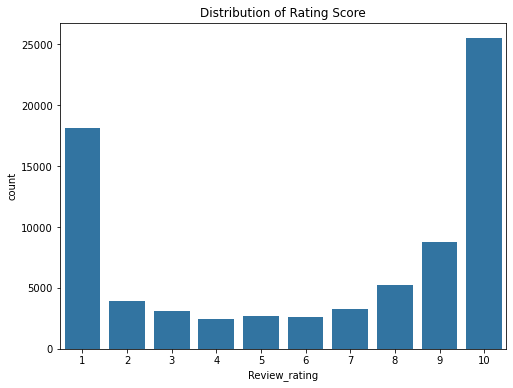

In [13]:
plt.figure(figsize = (8,6))
sns.countplot(df_raw['Review_rating'], color = 'tab:blue')
plt.title('Distribution of Rating Score')
plt.show()

That's not what we expected, grabbing more review from bad movies only balance the the `1` score, everything else still appear much less than the 2 dominant classes. We will have to deal with them later.

##### 2.2.2. Comments count over time

Let's check the popularity of these movies over the years:

In [14]:
df_raw['year'] = df_raw['Review_date'].dt.to_period('y') #Create new column by extracting the year in the review date
df_raw_by_year = df_raw.groupby('year')[['Review_rating']].count() #count the number of reviews by year and save as new colum
df_raw_by_year = df_raw_by_year.reset_index() #reset the index
df_raw_by_year.columns = ['year', 'Review_count'] #Change the name of the columns

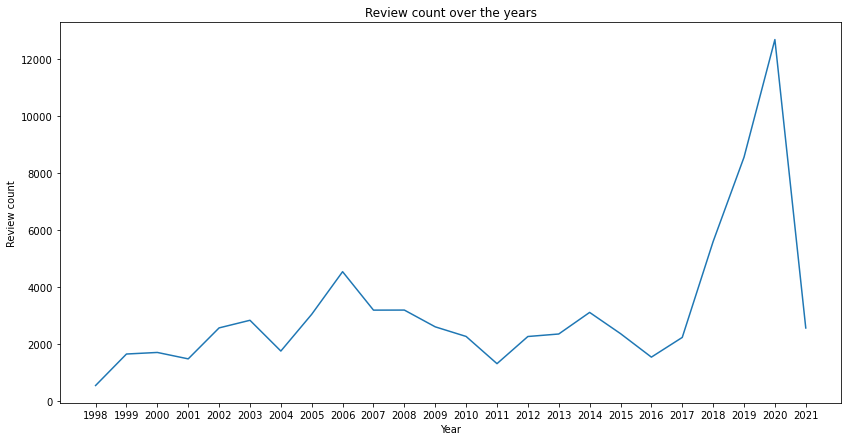

In [15]:
#plot the review count over the years
plt.figure(figsize = (14,7))
plt.plot(df_raw_by_year['year'].astype(str), #Convert data type of `year` column to str
         df_raw_by_year['Review_count']) # it's actually the number of reviews sum up for each year
plt.xlabel('Year')
plt.ylabel('Review count')
plt.title('Review count over the years')
plt.show()

One quick speculation here is that the number of reviews over the years for these movies are quite consistent, except in 2020 when it jumped almost 3 times the normal amount. Probably due to the pandemic and a lot of people has to stay home and watch movies.

#### 2.2.3. Cleaning and Stemming text

In order to analyzing the text properly, we need to clean them first with several step, e.g. make them all lower case, remove number, remove stop words, remove punctuation and stemming the words.  
For this, we will define a new class to and it's method to clean our text data:

In [16]:
class CleanText(BaseEstimator, TransformerMixin):
    '''
    Define class and method to clean text data to prepare for vectorizer.
    Reference: Copied from 'https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27'
    Note: There is some slight modification to fit my project
    
    '''
   
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer() #Using PorterStemmer as stemming method
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

We can now use it to clean out body text now, which is the data we will use to perform prediction:

In [17]:
#Instantiate the class method
clean = CleanText()
#Fit and transform `Review_body` column
body = clean.fit_transform(df_raw['Review_body'])

In [ ]:
#export cleantext method to a joblib file for our webapp
joblib.dump(clean, 'clean_text.joblib')

After cleaning, we can do some quick observations. Let's see what is the most common words in our data and plot them out:

In [18]:
#We can then use count the most common words in our copus
body_most_common = Counter(" ".join(body).split()).most_common(15) #split the words, separate by space '_' and get the top 15 most common words.
body_mc_word = [body_most_common[i][0] for i in range(len(body_most_common))] #Extract the word
body_mc_freq = [body_most_common[i][1] for i in range(len(body_most_common))] #Extract the frequency

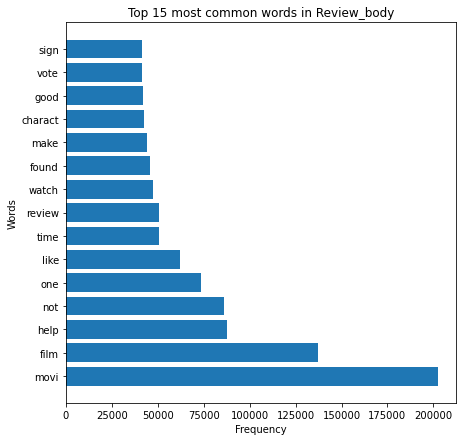

In [19]:
plt.figure(figsize = (7,7))
plt.barh(body_mc_word, body_mc_freq)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title("Top 15 most common words in Review_body")
plt.show()

Beside some obvious words like 'movie' or 'film'... We can see that 'time', 'help', 'charact' are one of the most frequent words in a review. It can give us a hint of what reviewers want to talk about.

### 2.3. Balance classes

As mentioned before, our data is heavily imbalance with class 1 and 10 take a majority.  
After some research and experiment, I decided to use down-sampling with imblearn library. As even after down-sampling, we can still maintain around 25k data points, which is enough for NPL modeling.

In [20]:
#First we will need to define our feature and target columns
X = df_raw[['Review_body']] #We will using only review_body as the feature
y = df_raw['Review_rating'] #Our target is the rating

In [21]:
#Then using imblearn to downsampling
sampling_strategy = "not minority" #Chose to downsampling every classes except the minority class (4 in our case)
#Instantiate the model
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
#fit/resampling
X_res, y_res = rus.fit_resample(X, y)

Then we can check the distribution of our resampled data:

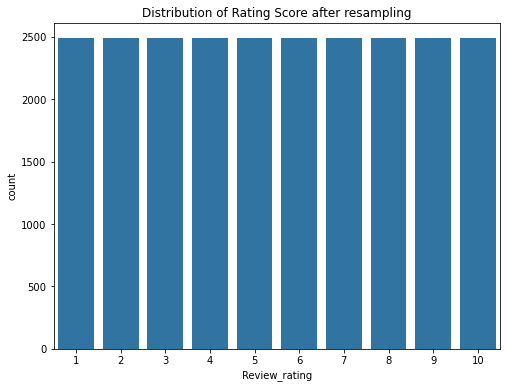

In [22]:
plt.figure(figsize = (8,6))
sns.countplot(y_res, color = 'tab:blue')
plt.title('Distribution of Rating Score after resampling')
plt.show()

We can then combine them back to a cleaned dataframe, ready for our modeling step.

In [23]:
#Combine X_res and y_res into cleaned dataframe
df= X_res.copy()
df['Review_rating'] = y_res
df.head()

,Review_body,Review_rating
0,I watched this movie and all I can say is........,1
1,"Seriously, not even a good way to waste 90 min...",1
2,This film is completely overrated. Having seen...,1
3,It is just a rubbish movie specially made to h...,1
4,In this film they manipulated the history of G...,1
...,...,...
24875,"First things first, Nolan had redefined ""Batma...",10
24876,The epic is one of movies most profitable and ...,10
24877,"I am gonna be real, but this was of my best mo...",10
24878,It's the best film ever! There is no moment wi...,10


Then we can write them back to a csv file. 
As we will use Google Colab to take advantage of its GPU, we will upload this clean `csv` file to Amazon S3 for easy access.

In [24]:
#Write down cleaned df to csv file
df.to_csv('Data/review_cleaned_final.csv', 
          index = False) # Chose to ignore index when writing to file

The modeling part will be continued in the next notebook: `Part3_modeling`